In [1]:
!pip install -q tflite-model-maker

     |████████████████████████████████| 593kB 4.0MB/s 
     |████████████████████████████████| 1.2MB 6.0MB/s 
     |████████████████████████████████| 92kB 7.1MB/s 
     |████████████████████████████████| 112kB 14.7MB/s 
     |████████████████████████████████| 71kB 6.0MB/s 
     |████████████████████████████████| 849kB 12.9MB/s 
     |████████████████████████████████| 122kB 17.2MB/s 
     |████████████████████████████████| 686kB 18.1MB/s 
     |████████████████████████████████| 645kB 21.7MB/s 
     |████████████████████████████████| 215kB 21.5MB/s 
     |████████████████████████████████| 6.3MB 22.5MB/s 
     |████████████████████████████████| 1.1MB 28.2MB/s 
     |████████████████████████████████| 358kB 35.0MB/s 
     |████████████████████████████████| 37.2MB 128kB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 204kB 38.4MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm,trange
from sklearn.model_selection import train_test_split
import sklearn.metrics

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install pytorchcv --quiet
from pytorchcv.model_provider import get_model
model = get_model("xception", pretrained=True)
# model = get_model("resnet18", pretrained=True)
model = nn.Sequential(*list(model.children())[:-1]) # Remove original output layer

     |████████████████████████████████| 532kB 3.8MB/s 


In [4]:
model[0].final_block.pool = nn.Sequential(nn.AdaptiveAvgPool2d(1))

In [5]:
class Head(torch.nn.Module):
  def __init__(self, in_f, out_f):
    super(Head, self).__init__()
    
    self.f = nn.Flatten()
    self.l = nn.Linear(in_f, 512)
    self.d = nn.Dropout(0.75)
    self.o = nn.Linear(512, out_f)
    self.b1 = nn.BatchNorm1d(in_f)
    self.b2 = nn.BatchNorm1d(512)
    self.r = nn.ReLU()

  def forward(self, x):
    x = self.f(x)
    x = self.b1(x)
    x = self.d(x)

    x = self.l(x)
    x = self.r(x)
    x = self.b2(x)
    x = self.d(x)

    out = self.o(x)
    return out

In [6]:
class FCN(torch.nn.Module):
  def __init__(self, base, in_f):
    super(FCN, self).__init__()
    self.base = base
    self.h1 = Head(in_f, 1)
  
  def forward(self, x):
    x = self.base(x)
    return self.h1(x)

model = FCN(model, 2048)

In [7]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jeejeeyoung","key":"9ac1aa0685cbd6493cfb8ae6fc1a67bb"}'}

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!cd /content
!kaggle datasets download -d greatgamedota/ffhq-face-data-set

100% 1.97G/1.97G [00:15<00:00, 145MB/s]
100% 1.97G/1.97G [00:15<00:00, 134MB/s]


In [10]:
%%capture
!mkdir ffhq-face-data-set
!unzip ffhq-face-data-set.zip -d ffhq-face-data-set

In [11]:
cd /content

/content


In [12]:
!kaggle datasets download -d unkownhihi/deepfake

100% 763M/763M [00:07<00:00, 80.1MB/s]
100% 763M/763M [00:07<00:00, 109MB/s] 


In [13]:
%%capture
!mkdir deepfake
!unzip deepfake.zip -d deepfake

In [14]:
TRAIN_DIR = '/content/deepfake'
#SAVE_DIR = '/content/drive/MyDrive/2021Hanium_deepfakeDetectionApplication/Kim_jeeyoung_folder/deepfake-detection-challenge/train_images'
#folders = os.listdir(TRAIN_DIR)
#folders.remove("metadata.json")

In [15]:
import glob
train_images = []
for num in tqdm(range(0,49)) :
  TRAIN_PATH = f'/content/deepfake/DeepFake0{num}/DeepFake0{num}'
  all_train_images = glob.glob(os.path.join(TRAIN_PATH,'*jpg'))
  train_images.extend(all_train_images)

json_files = glob.glob(os.path.join('/content/deepfake','*.json'))

100%|██████████| 49/49 [00:00<00:00, 834.82it/s]


In [16]:
df_tempJson = pd.read_json(json_files[0])
df_json = pd.DataFrame(df_tempJson)

for j in range(len(json_files)):
  df_tempJson = pd.read_json(json_files[j])
  if j==0 : df_json = pd.DataFrame(df_tempJson)
  else:
    df_json = pd.concat([pd.DataFrame(df_tempJson),df_json],axis=1)

In [17]:
def read_img(path):
  return cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)

In [18]:
import random
real = []
fake = []
for path in tqdm(train_images):
    file_name = path.split('/')[-1]
    file_name = file_name.split('.')[0] + '.mp4'

    if df_json[file_name]['label'] == 'FAKE':
        fake.append(path)
    else:
        real.append(path)
        

fake = random.sample(fake,len(real))
paths, Y =[], []

for x in real:
    paths.append(read_img(x))
    Y.append(0)
for x in fake:
    paths.append(read_img(x))
    Y.append(1)

100%|██████████| 18842/18842 [00:01<00:00, 16880.09it/s]


In [19]:
def shuffle(X,y):
    new_train=[]
    for m,n in zip(X,y):
        new_train.append([m,n])
    random.shuffle(new_train)
    X,y=[],[]
    for x in new_train:
        X.append(x[0])
        y.append(x[1])
    return X,y

In [20]:
paths,y=shuffle(paths,Y)  

In [21]:
len(paths)

4820

In [22]:
ffhq = os.listdir('/content/ffhq-face-data-set/thumbnails128x128')

In [23]:
X_ = []
for file in tqdm(ffhq):
  im = read_img(f'/content/ffhq-face-data-set/thumbnails128x128/{file}')
  im = cv2.resize(im, (150,150))
  X_.append(im)
random.shuffle(X_)

100%|██████████| 70000/70000 [01:06<00:00, 1051.19it/s]


In [24]:
for image in tqdm(X_):
  paths.append(image)
  y.append(0)

100%|██████████| 70000/70000 [00:00<00:00, 1226671.12it/s]


In [25]:
paths,y=shuffle(paths,y)  

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val=train_test_split(paths,y,test_size=0.15)

In [27]:
print('There are '+str(y_train.count(1))+' fake train samples')
print('There are '+str(y_train.count(0))+' real train samples')
print('There are '+str(y_val.count(1))+' fake val samples')
print('There are '+str(y_val.count(0))+' real val samples')

There are 2058 fake train samples
There are 61539 real train samples
There are 352 fake val samples
There are 10871 real val samples


In [28]:
!pip install albumentations

     |████████████████████████████████| 634kB 3.0MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp37-none-any.whl size=654019 sha256=a94268f42437118cba2b04ad9141c8c9e34093647eeb05123d07b530eb710172
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [29]:
from torch.utils.data import Dataset, DataLoader
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

class ImageDataset(Dataset):
    def __init__(self, X, y, training=True, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img = self.X[idx]

        if self.transform is not None:
          res = self.transform(image=img)
          img = res['image']
        
        img = np.rollaxis(img, 2, 0)
        # img = np.array(img).astype(np.float32) / 255.

        labels = self.y[idx]
        labels = np.array(labels).astype(np.float32)
        return [img, labels]

In [30]:
import albumentations
from albumentations.augmentations.transforms import ShiftScaleRotate, HorizontalFlip, Normalize, RandomBrightnessContrast, MotionBlur, Blur, GaussNoise, JpegCompression
train_transform = albumentations.Compose([
                                          ShiftScaleRotate(p=0.3, scale_limit=0.25, border_mode=1, rotate_limit=25),
                                          HorizontalFlip(p=0.2),
                                          RandomBrightnessContrast(p=0.3, brightness_limit=0.25, contrast_limit=0.5),
                                          MotionBlur(p=.2),
                                          GaussNoise(p=.2),
                                          JpegCompression(p=.2, quality_lower=50),
                                          Normalize()
])
val_transform = albumentations.Compose([
                                          Normalize()
])

train_dataset = ImageDataset(X_train, y_train, transform=train_transform)
val_dataset = ImageDataset(X_val, y_val, transform=val_transform)

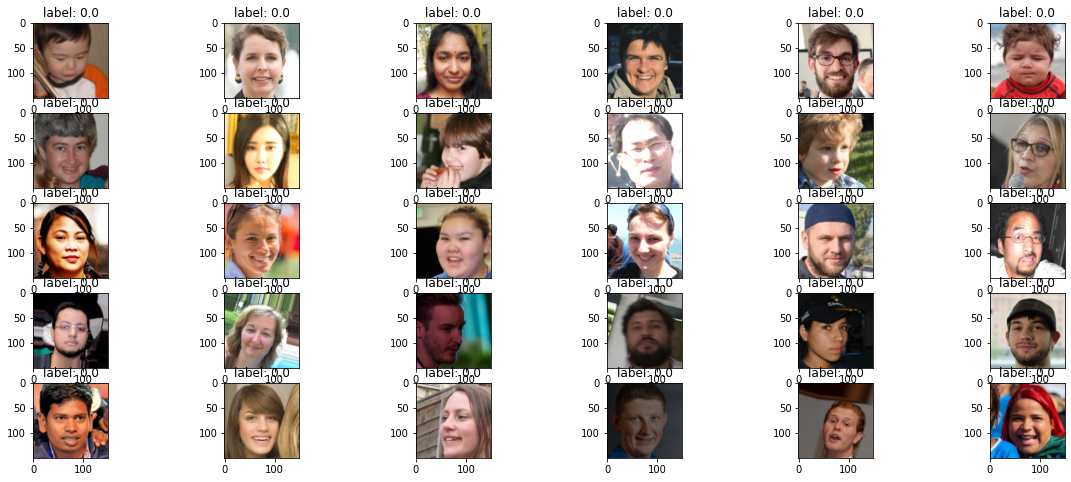

In [31]:
nrow, ncol = 5, 6
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    image, label = train_dataset[i]
    image = np.rollaxis(image, 0, 3)
    image = image*std + mean
    image = np.clip(image, 0., 1.)
    ax.imshow(image)
    ax.set_title(f'label: {label}')

In [32]:
def criterion1(pred1, targets):
  targets = targets.view(-1,1)
  l1 = F.binary_cross_entropy(F.sigmoid(pred1), targets)
  return l1

def train_model(epoch, optimizer, scheduler=None, history=None):
    model.train()
    total_loss = 0
    
    t = tqdm(train_loader)
    for i, (img_batch, y_batch) in enumerate(t):
        img_batch = img_batch.cuda().float()
        y_batch = y_batch.cuda().float()

        optimizer.zero_grad()

        out = model(img_batch)
        loss = criterion1(out, y_batch)

        total_loss += loss
        t.set_description(f'Epoch {epoch+1}/{n_epochs}, LR: %6f, Loss: %.4f'%(optimizer.state_dict()['param_groups'][0]['lr'],total_loss/(i+1)))

        if history is not None:
          history.loc[epoch + i / len(X_train), 'train_loss'] = loss.data.cpu().numpy()
          history.loc[epoch + i / len(X_train), 'lr'] = optimizer.state_dict()['param_groups'][0]['lr']

        loss.backward()
        optimizer.step()
        if scheduler is not None:
          scheduler.step()

def evaluate_model(epoch, scheduler=None, history=None):
    model.eval()
    loss = 0
    pred = []
    real = []
    with torch.no_grad():
        for img_batch, y_batch in val_loader:
            img_batch = img_batch.cuda().float()
            y_batch = y_batch.cuda().float()

            o1 = model(img_batch)
            l1 = criterion1(o1, y_batch)
            loss += l1
            
            for j in o1:
              pred.append(F.sigmoid(j))
            for i in y_batch:
              real.append(i.data.cpu())
    
    pred = [p.data.cpu().numpy() for p in pred]
    pred2 = pred
    pred = [np.round(p) for p in pred]
    pred = np.array(pred)
    acc = sklearn.metrics.recall_score(real, pred, average='macro')

    real = [r.item() for r in real]
    pred2 = np.array(pred2).clip(0.1, 0.9)
    kaggle = sklearn.metrics.log_loss(real, pred2)

    loss /= len(val_loader)
    
    if history is not None:
        history.loc[epoch, 'dev_loss'] = loss.cpu().numpy()
    
    if scheduler is not None:
      scheduler.step(loss)

    print(f'Dev loss: %.4f, Acc: %.6f, Kaggle: %.6f'%(loss,acc,kaggle))
    
    return loss

In [33]:
MODEL_PATH = '/content/drive/MyDrive/2021Hanium_deepfakeDetectionApplication/Kim_jeeyoung_folder/model.pth'

In [34]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import gc

history = pd.DataFrame()
history2 = pd.DataFrame()

torch.cuda.empty_cache()
gc.collect()

best = 1e10
n_epochs = 20
batch_size = 128

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

model = model.cuda()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, mode='min', factor=0.7, verbose=True, min_lr=1e-5)

for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()

    train_model(epoch, optimizer, scheduler=None, history=history)
    
    loss = evaluate_model(epoch, scheduler=scheduler, history=history2)
    
    if loss < best:
      best = loss
      print(f'Saving best model...')
      torch.save(model.state_dict(), MODEL_PATH)

Epoch 1/20, LR: 0.001000, Loss: 0.2801: 100%|██████████| 497/497 [03:59<00:00,  2.07it/s]


Dev loss: 0.1066, Acc: 0.500000, Kaggle: 0.174275
Saving best model...


Epoch 2/20, LR: 0.001000, Loss: 0.0740: 100%|██████████| 497/497 [04:00<00:00,  2.07it/s]


Dev loss: 0.0423, Acc: 0.852297, Kaggle: 0.137821
Saving best model...


Epoch 3/20, LR: 0.001000, Loss: 0.0593: 100%|██████████| 497/497 [04:00<00:00,  2.07it/s]


Dev loss: 0.0400, Acc: 0.896372, Kaggle: 0.137239
Saving best model...


Epoch 4/20, LR: 0.001000, Loss: 0.0529: 100%|██████████| 497/497 [04:00<00:00,  2.07it/s]


Dev loss: 0.0401, Acc: 0.943788, Kaggle: 0.137508


Epoch 5/20, LR: 0.001000, Loss: 0.0481: 100%|██████████| 497/497 [04:00<00:00,  2.07it/s]


Dev loss: 0.0360, Acc: 0.891748, Kaggle: 0.134170
Saving best model...


Epoch 6/20, LR: 0.001000, Loss: 0.0475: 100%|██████████| 497/497 [04:00<00:00,  2.07it/s]


Dev loss: 0.0366, Acc: 0.915482, Kaggle: 0.133859


Epoch 7/20, LR: 0.001000, Loss: 0.0440: 100%|██████████| 497/497 [04:00<00:00,  2.07it/s]


Dev loss: 0.0359, Acc: 0.921072, Kaggle: 0.134100
Saving best model...


Epoch 8/20, LR: 0.001000, Loss: 0.0419: 100%|██████████| 497/497 [03:59<00:00,  2.07it/s]


Dev loss: 0.0333, Acc: 0.826694, Kaggle: 0.131449
Saving best model...


Epoch 9/20, LR: 0.001000, Loss: 0.0409: 100%|██████████| 497/497 [03:59<00:00,  2.07it/s]


Dev loss: 0.0331, Acc: 0.826832, Kaggle: 0.131055
Saving best model...


Epoch 10/20, LR: 0.001000, Loss: 0.0392: 100%|██████████| 497/497 [03:59<00:00,  2.07it/s]


Dev loss: 0.0285, Acc: 0.915079, Kaggle: 0.126877
Saving best model...


Epoch 11/20, LR: 0.001000, Loss: 0.0359: 100%|██████████| 497/497 [03:59<00:00,  2.07it/s]


Dev loss: 0.0308, Acc: 0.865276, Kaggle: 0.128345


Epoch 12/20, LR: 0.001000, Loss: 0.0391: 100%|██████████| 497/497 [03:59<00:00,  2.07it/s]


Dev loss: 0.0345, Acc: 0.926432, Kaggle: 0.132676


Epoch 13/20, LR: 0.001000, Loss: 0.0347: 100%|██████████| 497/497 [03:59<00:00,  2.07it/s]


Dev loss: 0.0296, Acc: 0.935420, Kaggle: 0.127958


Epoch 14/20, LR: 0.001000, Loss: 0.0329:   7%|▋         | 33/497 [00:16<03:43,  2.08it/s]